Python library:
- numpy
- matplotlib
- numba
- scipy

Animation require ffmpeg

In [1]:
from numba import njit
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation

# Change to where ffmpeg.exe is to make animation
# mpl.rcParams[
#     "animation.ffmpeg_path"
# ] = r"ffmpeg.exe"


# Dark theme look great! right?
plt.style.use("dark_background")

It is important to note that the potential convex cannot be too deep.
Otherwise, particles gain too much kinetic energy and time step need lowered.

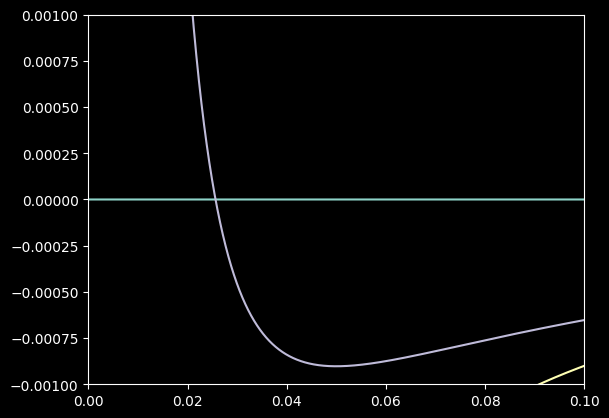

In [2]:
import scipy.integrate

fig = plt.figure()
plt.plot()
x = np.linspace(1e-15, 1, 100000)


plt.xlim([0, 0.1])
plt.ylim([-0.001, 0.001])

# horizontal line
plt.plot(x, np.zeros_like(x))


def force(x):
    const_g = 1e-4
    return const_g / x**2


def force2(x):
    const_g = 1e-4
    const_r = 5e-6
    return const_g / x**2 - const_r / x**3


# potential = integrate force..
y2 = scipy.integrate.cumulative_trapezoid(force(x[::-1]), x[::-1], initial=0)[::-1]
plt.plot(x, y2)

y3 = scipy.integrate.cumulative_trapezoid(force2(x[::-1]), x[::-1], initial=0)[::-1]
plt.plot(x, y3)

`x0` is N-by-4 array. A particle is represented by `x0[i, :]` and the values are x-position, y-position, x-velocity, and y-velocity.

The domain is restricted to the box, `[0, 1] x [0, 1]`. 

In [3]:
@njit(inline="always")
def elastic_boundary(x0):
    size = x0.shape[0]
    assert x0.shape[1] == 4

    for i in range(size):
        if x0[i, 0] < 0:
            x0[i, 0] = -x0[i, 0]
            x0[i, 2] = -x0[i, 2]
        elif x0[i, 0] > 1:
            x0[i, 0] = 2 - x0[i, 0]
            x0[i, 2] = -x0[i, 2]

        if x0[i, 1] < 0:
            x0[i, 1] = -x0[i, 1]
            x0[i, 3] = -x0[i, 3]
        elif x0[i, 1] > 1:
            x0[i, 1] = 2 - x0[i, 1]
            x0[i, 3] = -x0[i, 3]


@njit(inline="always")
def periodic_boundary(x0):
    # impose the periodic boundary.
    # assume masses are slowing enough, ie. position in the interval (-1, 2)
    size = x0.shape[0]
    assert x0.shape[1] == 4

    for i in range(size):
        if x0[i, 0] < 0:
            x0[i, 0] += 1
        elif x0[i, 0] > 1:
            x0[i, 0] -= 1

        if x0[i, 1] < 0:
            x0[i, 1] += 1
        elif x0[i, 1] > 1:
            x0[i, 1] -= 1

In [4]:
@njit()
def derivative(y, x, masses):
    assert y.shape == x.shape, "Bad shape"
    assert x.shape[0] == masses.shape[0]
    assert x.shape[1] == 4

    size = x.shape[0]

    const_g = 1e-4  # the gravitational constant
    const_r = 5e-6  # the repuslion

    # Thanks to memory access pattern, pure-loop may be faster than vectorization

    # 1. Assign derivative of positions
    # 2. Zero derivative of velocities
    for i in range(size):
        y[i, 0] = x[i, 2]  # d/dt r_x
        y[i, 1] = x[i, 3]  # d/dt r_y
        y[i, 2] = 0  # d/dt v_x
        y[i, 3] = 0  # d/dt v_y

    # Compute derivative of velocities
    for i in range(size):
        for j in range(i + 1, size):
            fx = 0.0
            fy = 0.0

            # a = b = 0 is the center
            # For periodic boundary,
            # there are 8 other shallow masses outside the domain
            # this is an approximation good enough for our purpose.
            # Ewald summation is an even better approximation

            for a in (-1.0, 0.0, 1.0):
                for b in (-1.0, 0.0, 1.0):
                    dx = x[j, 0] - x[i, 0] + a
                    dy = x[j, 1] - x[i, 1] + b
                    r_reci = 1 / np.sqrt(dx * dx + dy * dy)
                    cof = const_g * r_reci**3 - const_r * r_reci**4
                    fx += cof * dx
                    fy += cof * dy

            # If precision is needed, may apply Kahan summation.
            # But another temp array need allocate or pass to this function.
            y[i, 2] += fx * masses[j]
            y[i, 3] += fy * masses[j]

            # based on symmetry, the opposite force is also applied on the j-th mass
            y[j, 2] -= fx * masses[i]
            y[j, 3] -= fy * masses[i]


@njit
def rk4_run(x0, masses, steps, h):
    # https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods

    k1 = np.empty_like(x0)
    k2 = np.empty_like(x0)
    k3 = np.empty_like(x0)
    k4 = np.empty_like(x0)

    half = h / 2

    for _ in range(steps):
        derivative(k1, x0, masses)
        derivative(k2, x0 + k1 * half, masses)
        derivative(k3, x0 + k2 * half, masses)
        derivative(k4, x0 + k3 * half, masses)

        x0 = x0 + (k1 + k2 * 2 + k3 * 2 + k4) * h / 6

        periodic_boundary(x0)

    return x0

In [ ]:
#  Disasm the compiled function for optimization :(
np.random.seed(12346)
x0 = np.random.random_sample((2, 4))
masses = np.ones((x0.shape[0],))
x1 = rk4_run(x0, masses, 2, 0.01)
print(x1)

for k, v in rk4_run.inspect_asm().items():
    print(k)
    print(v)

In [ ]:
# Generate animation

total_time = 30
time_scale = 2
frame_per_second = 24
steps_per_second = 1000
h = 0.001
size = 20

np.random.seed(1234)

# masses = np.ones((size,))
# x0 = np.random.random_sample((size, 4))
# # position from Uniform[0, 1)
# # velocity from uniform [-0.005, 0.005]
# x0[:, 2:4] -= 0.5
# x0[:, 2:4] *= 0.2  # reduce speed


masses = np.ones((size,))
spacing = np.arange(0, 2 * np.pi, 2 * np.pi / size)
x0 = np.zeros((size, 4))
x0[:, 0] = 0.5 + np.sin(spacing) * 0.25
x0[:, 1] = 0.5 + np.cos(spacing) * 0.25
x0[:, 2] = -0.04 * np.cos(spacing)
x0[:, 3] = 0.04 * np.sin(spacing)


def draw(n):
    global x0

    frame_duration = 1 / frame_per_second
    sim_duration = time_scale * frame_duration
    steps = sim_duration / h

    if n > 0:
        x0 = rk4_run(x0, masses, int(steps), h)

    # ke = (masses * (x0[:, 2] ** 2 + x0[:, 3] ** 2)).sum()
    # print(f"{n}: KE={ke:.3f} {x0[:, 2].min():.3f} {x0[:, 2].max():.3f}")

    path.set_offsets(x0[:, 0:2])

    return [path]


fig = plt.figure()
ax = fig.add_subplot()
ax.set_aspect(1)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel("x")
ax.set_ylabel("y")

txt_title = ax.set_title("")

path = ax.scatter(x0[:, 0], x0[:, 1], masses * 10)
# print(path)

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(
    fig,
    draw,
    frames=int(total_time * frame_per_second),
    interval=1 / frame_per_second * 1000,
    blit=True,
)
from IPython.display import HTML

HTML(anim.to_html5_video())

In [ ]:
col = 4
fig, axs = plt.subplots(4, col)

n = 3
np.random.seed(12345)
x0 = np.random.random_sample((n, 4))
x0[:, 2:4] *= 0.01
masses = np.ones((n,))

for i, ax in enumerate(axs.flat):
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_aspect(1)

    if i:
        x0 = rk4_run(x0, masses, 100, 0.01)

    ax.scatter(x0[:, 0], x0[:, 1])
    print(x0[:, 0].max(), x0[:, 2].max())

In [5]:
# Compute trajectory

total_time = 20
time_scale = 2
frame_per_second = 24
steps_per_second = 1000
h = 0.005
size = 20

np.random.seed(1234)

masses = np.ones((size,))
# masses[::2] = 2
spacing = np.arange(0, 2 * np.pi, 2 * np.pi / size)
x0 = np.zeros((size, 4))
x0[:, 0] = 0.5 + np.sin(spacing) * 0.25
x0[:, 1] = 0.5 + np.cos(spacing) * 0.25
x0[:, 2] = -0.04 * np.cos(spacing)
x0[:, 3] = 0.04 * np.sin(spacing)


trajectory = np.zeros((total_time * frame_per_second, size, 2))


for i in range(total_time * frame_per_second):
    frame_duration = 1 / frame_per_second
    sim_duration = time_scale * frame_duration
    steps = sim_duration / h

    if i > 0:
        x0 = rk4_run(x0, masses, int(steps), h)

    trajectory[i, :, :] = x0[:, 0:2]

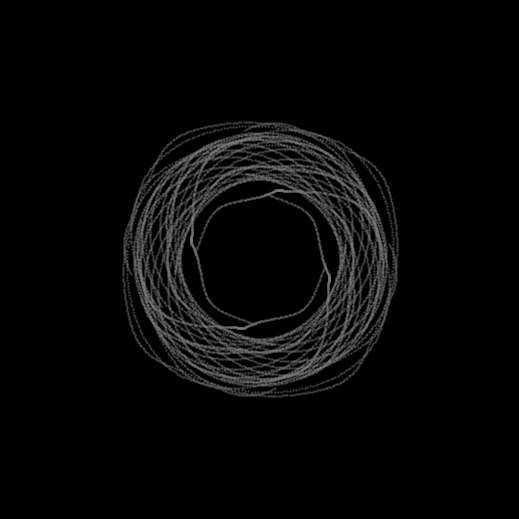

In [6]:
# Plot trajectory with scatter

plt.style.use("dark_background")
fig = plt.figure(figsize=(5, 5))
ax = plt.Axes(fig, [0, 0, 1, 1])
ax.set_axis_off()
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
fig.add_axes(ax)

for k in range(trajectory.shape[1]):
    plt.scatter(trajectory[:, k, 0], trajectory[:, k, 1], 1, alpha=0.3, c="gray")


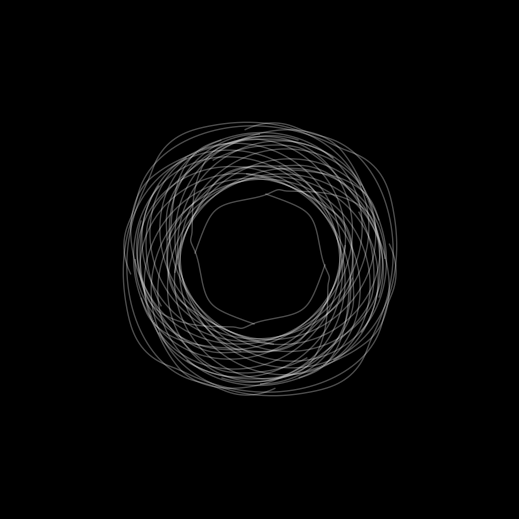

In [10]:
# Plot trajectory with Path

import matplotlib.path as mpath
import matplotlib.patches as mpatches


@njit
def compute_path(
    trajectory,
    _code_type=mpath.Path.code_type,
    _MOVETO=mpath.Path.MOVETO,
    _LINETO=mpath.Path.LINETO,
):
    steps, _ = trajectory.shape

    vertices = trajectory[:, 0:2]
    codes = np.full((steps,), _LINETO, dtype=_code_type)
    codes[0] = _MOVETO

    for i in range(steps - 1):
        ds = np.abs(trajectory[i + 1, :] - trajectory[i, :]).max()
        if ds >= 0.5:
            codes[i + 1] = _MOVETO

    return vertices, codes


plt.style.use("dark_background")
fig = plt.figure(figsize=(5, 5))
ax = plt.Axes(fig, [0, 0, 1, 1])
ax.set_axis_off()
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
fig.add_axes(ax)

for k in range(trajectory.shape[1]):
    vertices, codes = compute_path(trajectory[:, k, :])
    patch = mpatches.PathPatch(
        mpath.Path(vertices, codes),
        fc="none",
        alpha=0.3,
    )
    ax.add_patch(patch)


# plt.savefig("track.png", dpi=1200)

Useful commands for processing the output image:

`convert track.png -scale 1024x1024 out.png`